In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

In [31]:
file_path = "./features/cc_all2.csv"  # Update this if needed
df = pd.read_csv(file_path)


In [32]:
X = df.drop(columns=["Mol", "Result"])  # Exclude non-numeric columns
y = df["Result"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature scaling (Decision Trees don't require scaling, but useful for comparisons)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Decision Tree model
tree = DecisionTreeClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    "criterion": ["gini", "entropy"],    # Split criteria
    "max_depth": [3, 5, 7, 10, None],       # Tree depth
    "min_samples_split": [2, 5, 10],     # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],       # Minimum samples in a leaf
}

grid_search = GridSearchCV(tree, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get best parameters and train final model
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_tree = DecisionTreeClassifier(**best_params, random_state=16)
best_tree.fit(X_train_scaled, y_train)

# Predictions
y_pred = best_tree.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
y_prob = best_tree.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)



Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Model Accuracy: 0.8571

Classification Report:
               precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.67      0.80         3

    accuracy                           0.86         7
   macro avg       0.90      0.83      0.84         7
weighted avg       0.89      0.86      0.85         7



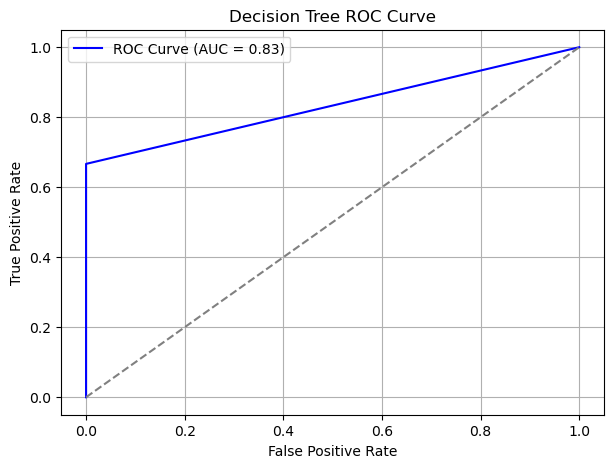

In [33]:
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend()
plt.grid()
plt.show()